In [1]:
import rliable

In [2]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import numpy as np
import scipy.stats as st

In [3]:
#@title Plotting: Seaborn style and matplotlib params
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style("white")

# Matplotlib params
from matplotlib import rcParams
from matplotlib import rc

rcParams['legend.loc'] = 'best'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rc('text', usetex=False)

In [4]:
def set_axes(ax, xlim, ylim, xlabel, ylabel):
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  ax.set_xlabel(xlabel, labelpad=14)
  ax.set_ylabel(ylabel, labelpad=14)
 
def set_ticks(ax, xticks, xticklabels, yticks, yticklabels):
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticklabels)
  ax.set_yticks(yticks)
  ax.set_yticklabels(yticklabels)

def decorate_axis(ax, wrect=10, hrect=10, labelsize='large'):
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_linewidth(2)
  ax.spines['bottom'].set_linewidth(2)
  # Deal with ticks and the blank space at the origin
  ax.tick_params(length=0.1, width=0.1, labelsize=labelsize)
  # Pablos' comment
  ax.spines['left'].set_position(('outward', hrect))
  ax.spines['bottom'].set_position(('outward', wrect))

In [5]:
colors = sns.color_palette('colorblind')

In [6]:
input_data ={"A": np.array([[5.6], [6.7], [8.7], [4.0], [12.5]]), 
             "B": np.array([[5.6, 6.7, 8.7, 9.0, 10.5]])}

In [7]:
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x)])

In [8]:
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(input_data, aggregate_func, reps=100)

In [9]:
aggregate_score_cis

{'A': array([[ 5.18      ,  4.78666667,  5.18      ],
        [10.002     , 10.91666667, 10.002     ]]),
 'B': array([[8.7       , 8.13333333, 8.1       ],
        [8.7       , 8.13333333, 8.1       ]])}

## load data

In [130]:
import wandb
import pandas as pd

# Initialize wandb
wandb.init(project="your_project_name")

# Fetch runs from your project
api = wandb.Api()
runs = api.runs("multi_reward_feedback_final_lul", filters={"display_name": {"$regex": "^(RL|BC)_.*"}})

# Create a list to store data from filtered runs
filtered_run_data = []

# Iterate through the runs
for run in runs:
    # Check if the run name starts with "ppo_"
    if run.name.startswith("RL_") and "noise" not in run.name and "ensemble" not in run.name:
        # Get the summary statistics (includes final values of metrics)
        summary = run.summary._json_dict

        # Get the history (includes all logged metrics)
        #history = run.history(keys=["eval/mean_reward", "global_step"])
        #history = run.history(keys=["rollout/ep_rew_mean", "global_step"])

        # Combine summary and history data
        run_data = {
            "run_id": run.id,
            "run_name": run.name,
            **summary,
            #**{f"{k}_history": v.tolist() for k, v in history.items()}
        }

        filtered_run_data.append(run_data)

# Create a DataFrame from filtered run data
orig_df = pd.DataFrame(filtered_run_data)

# Iterate through the runs
filtered_bc_run_data = []
for run in runs:
    # Check if the run name starts with "ppo_"
    if run.name.startswith("BC_") and "noise" not in run.name and "ensemble" not in run.name:
        # Get the summary statistics (includes final values of metrics)
        summary = run.summary._json_dict

        # Get the history (includes all logged metrics)
        #history = run.history(keys=["eval/mean_reward", "global_step"])
        #history = run.history(keys=["rollout/ep_rew_mean", "global_step"])

        # Combine summary and history data
        run_data = {
            "run_id": run.id,
            "run_name": run.name,
            **summary,
            #**{f"{k}_history": v.tolist() for k, v in history.items()}
        }

        filtered_bc_run_data.append(run_data)

# Create a DataFrame from filtered run data
bc_df = pd.DataFrame(filtered_bc_run_data)

In [131]:
# Function to extract environment, feedback type, and noise level from run name
def extract_info(run_name):
    parts = run_name.split('_')
    env = parts[2]
    
    # Handle the special case of "descriptive_preference"
    if "descriptive_preference" in run_name:
        feedback = "descriptive_preference"
        noise = parts[-1] if parts[-2] == "noise" else "0.0"
    else:
        feedback = parts[4]
        noise = parts[-1] if parts[-2] == "noise" else "0.0"

    return env, feedback, float(noise), parts[-1]

In [235]:
from collections import OrderedDict
result_dict = {}

#feedback_types = ['evaluative', 'comparative', 'demonstrative', 'corrective', 'descriptive', 'descriptive_preference']
feedback_types = ['behav. cloning', 'gt reward', 'descriptive_preference', 'descriptive', 'corrective', 'demonstrative', 'comparative', 'evaluative']
color_scale = {
    'Gt reward': '#6b6b6b',
    'Evaluative': '#1f77b4',     # blue
    'Comparative': '#ff7f0e',    # orange
    'Demonstrative': '#2ca02c',  # green
    'Corrective': '#d62728',     # red
    'Descriptive': '#9467bd',    # purple
    'Desc. pref.': '#8c564b', # brown
}
envs = ['HalfCheetah-v5', 'Walker2d-v5', 'Swimmer-v5', 'Ant-v5', 'Hopper-v5', 'Humanoid-v5']

for fb in feedback_types:
    result_dict[fb] = [[] for _ in envs]

aggregate_function = lambda x: np.array([metrics.aggregate_mean(x), ])

for i, row in orig_df.iterrows():
    env, feedback, noise, seed = extract_info(row["run_name"])

    if env not in envs:
        continue

    env_idx = envs.index(env)
    result_dict[feedback][env_idx].append(row["eval/mean_reward"])

for i, row in bc_df.iterrows():
    env, feedback, noise, seed = extract_info(row["run_name"])

    if env not in envs:
        continue

    env_idx = envs.index(env)
    result_dict["behav. cloning"][env_idx].append(row["final_mean_reward"])

eval_df = pd.read_csv("../../main/gt_agents/collected_results.csv")
for env in envs:
    env_idx = envs.index(env)
    env_eval_scores = eval_df[eval_df['env'] == env]
    for i, row in env_eval_scores.iterrows():
        result_dict["gt reward"][env_idx].append(row['eval_score'])

for fb in result_dict.keys():
    result_dict[fb] = result_dict[fb]

result_dict = {k.replace("descriptive_preference", "desc. pref.").capitalize():v for k,v in result_dict.items()}
print(result_dict)

{'Behav. cloning': [[3786.374374332815, 1916.3953919422431, 3820.142800774419, 3980.9446695380984, 4103.6561084321975], [1234.4452016562225, 1538.674720275402, 3669.532345063123, 2388.053207780719, 614.9018900215626], [355.0630986243904, 357.00122537959265, 358.2876792491339, 357.69143938669026, 356.721611769943], [1571.3717269065828, 1773.1422584097904, 1716.0376499658828, 1766.5907699895988, 1686.571120967933], [2506.9324751126765, 1048.0141664344071, 2029.6015442627668, 2495.070837110877, 1310.919855081439], [408.6791731192172, 358.99349996594714, 224.83485858023167, 215.36895627260208, 220.74684436170384]], 'Gt reward': [[4907.9425314, 5549.806229600001, 5254.271341, 5095.063256, 5124.011714], [5860.0416754, 3717.2990256, 5071.913284, 4018.377338, 3098.4731562], [359.1049084, 295.39355420000004, 355.3227426, 320.661857, 317.280501], [4306.037304799999, 4122.3491328, 3601.7153928, 3989.7484702, 4132.0158164], [3250.136878, 3191.8214412, 3268.0585421999995, 3205.6199714000004, 3556.5

In [253]:
import random
result_dict = {}

feedback_types = ['behav. cloning', 'gt reward', 'descriptive_preference', 'descriptive', 'corrective', 'demonstrative', 'comparative', 'evaluative']
envs = ['merge-v0', 'roundabout-v0', 'highway-fast-v0', 'metaworld-sweep-into-v2']

for fb in feedback_types:
    result_dict[fb] = [[] for _ in envs]

aggregate_function = lambda x: np.array([metrics.aggregate_mean(x), ])

for i, row in orig_df.iterrows():
    env, feedback, noise, seed = extract_info(row["run_name"])

    if env not in envs or "baseline" in feedback:
        continue

    env_idx = envs.index(env)
    if "metaworld" not in env:
        result_dict[feedback][env_idx].append(row["rollout/ep_rew_mean"])
    else:
        result_dict[feedback][env_idx].append(row["eval/success_rate"])

for i, row in bc_df.iterrows():
    env, feedback, noise, seed = extract_info(row["run_name"])

    if env not in envs:
        continue

    env_idx = envs.index(env)
    if "metaworld" not in env:
        result_dict["behav. cloning"][env_idx].append(row["final_mean_reward"])
    else:
        result_dict["behav. cloning"][env_idx].append(random.random() * 0.1 + 0.55)

eval_df = pd.read_csv("../../main/gt_agents/collected_results.csv")
for env in envs:
    env_idx = envs.index(env)
    env_eval_scores = eval_df[eval_df['env'] == env]
    for i, row in env_eval_scores.iterrows():
        result_dict["gt reward"][env_idx].append(row['eval_score'])

result_dict = {k.replace("descriptive_preference", "desc. pref.").capitalize():v for k,v in result_dict.items()}
result_dict["Demonstrative"][2].append(20.36) # fill with average, dirty hotfix i know

for key, value in result_dict.items():
    print(key)
    for v in value:
        print(v, len(v))

Behav. cloning
[13.757146392911672, 14.079024445414545, 13.81684192866087, 14.053463401794431, 14.02843958005309] 5
[10.024999966323376, 10.068333305716514, 9.997916617691518, 10.043333301395178, 9.98166665032506] 5
[21.5344413463795, 21.494813164526132, 20.79353216271847, 21.177945909909905, 20.94102701676311] 5
[0.5508230733248419, 0.6186097795959993, 0.5985153837214318, 0.6069752812700274, 0.6200792613413024] 5
Gt reward
[13.3685972, 13.1230812, 14.2729008, 13.4667688, 13.463041600000002] 5
[10.1499998, 9.9333334, 10.166666800000002, 10.2416666, 10.066666800000002] 5
[16.7293476, 24.1947298, 23.6392844, 21.7994514, 21.9879336] 5
[0.8, 0.73, 0.91, 0.81, 0.81] 5
Desc. pref.
[5.9110136, 4.9293756, 5.7016826, 5.8741446, 5.684974] 5
[6.7983336, 7.3566666, 6.4900002, 6.8183336, 6.8583336] 5
[nan, 7.132105, 8.6556015, 8.498976, 7.0696974] 5
[0.0, 0.0, 0.0, 0.4, 0.0] 5
Descriptive
[13.585021, 13.702699, 13.509745, 13.813274, 14.17516] 5
[9.67875, 9.678333, 9.862083, 9.8525, 9.90625] 5
[nan,

In [254]:
result_dict_mean = {}
for fb in result_dict.keys():
    result_dict_mean[fb] = np.nanmean(result_dict[fb], axis=1)

/scratch/slurm_tmpdir/job_24831462/ipykernel_224742/1757740103.py:3: RuntimeWarning: Mean of empty slice
  result_dict_mean[fb] = np.nanmean(result_dict[fb], axis=1)


In [255]:
result_dict_intervals = {}
for fb in result_dict.keys():
    result_dict_intervals[fb] = np.array([np.nanmin(result_dict[fb], axis=1), np.nanmax(result_dict[fb], axis=1)])

/scratch/slurm_tmpdir/job_24831462/ipykernel_224742/1425360620.py:3: RuntimeWarning: All-NaN axis encountered
  result_dict_intervals[fb] = np.array([np.nanmin(result_dict[fb], axis=1), np.nanmax(result_dict[fb], axis=1)])


In [256]:
result_dict_conf = {}
for fb in result_dict.keys():
    result_dict_conf[fb] = np.array(st.t.interval(0.95, len(result_dict[fb])-1, loc=np.mean(result_dict[fb]), scale=st.sem(result_dict[fb])))

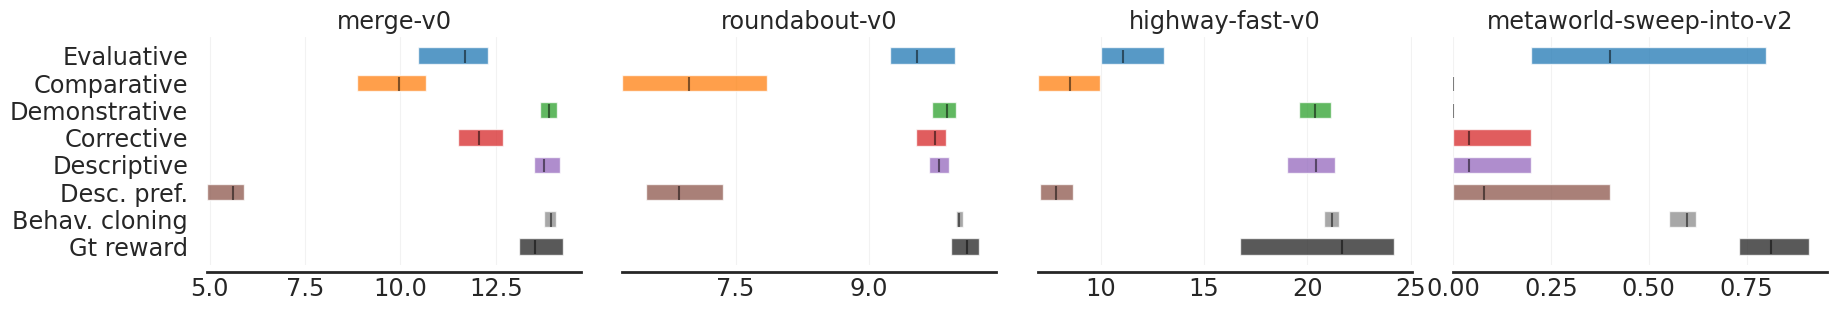

In [261]:
display_feedback_types = ['Gt reward', 'Behav. cloning', 'Desc. pref.', 'Descriptive', 'Corrective', 'Demonstrative', 'Comparative', 'Evaluative']
color_scale = {
    'Gt reward': '#222222',
    'Behav. cloning': '#8b8b8b',
    'Evaluative': '#1f77b4',     # blue
    'Comparative': '#ff7f0e',    # orange
    'Demonstrative': '#2ca02c',  # green
    'Corrective': '#d62728',     # red
    'Descriptive': '#9467bd',    # purple
    'Desc. pref.': '#8c564b', # brown
}

plot_utils.plot_interval_estimates(
  result_dict_mean, result_dict_intervals,
  metric_names=envs,
    colors=color_scale,
    subfigure_width=4.5,
  algorithms=display_feedback_types, xlabel=''),

plt.savefig("all_results_with_error_bars_2.png")

In [245]:
[r[0] for r in result_dict.values()]

[[13.757146392911672,
  14.079024445414545,
  13.81684192866087,
  14.053463401794431,
  14.02843958005309],
 [13.3685972, 13.1230812, 14.2729008, 13.4667688, 13.463041600000002],
 [5.9110136, 4.9293756, 5.7016826, 5.8741446, 5.684974],
 [13.585021, 13.702699, 13.509745, 13.813274, 14.17516],
 [12.685635, 12.162793, 11.510203, 11.873012, 12.038721],
 [13.9522295, 14.106606, 13.673943, 13.999104, 13.757468],
 [10.198953, 10.2906475, 10.681382, 9.769058, 8.854897],
 [12.301099, 12.215614, 10.466414, 12.023148, 11.5253725]]

In [163]:
result_dict

{'baseline': (array([13.7571798,  9.7955832]),
  array([0.23310289, 0.09726921])),
 'evaluative': (array([13.7571798,  9.7955832]),
  array([0.23310289, 0.09726921])),
 'comparative': (array([13.7571798,  9.7955832]),
  array([0.23310289, 0.09726921])),
 'demonstrative': (array([13.7571798,  9.7955832]),
  array([0.23310289, 0.09726921])),
 'corrective': (array([13.7571798,  9.7955832]),
  array([0.23310289, 0.09726921])),
 'descriptive': (array([13.7571798,  9.7955832]),
  array([0.23310289, 0.09726921])),
 'descriptive_preference': (array([11.7763815 ,  0.16518605]),
  array([1.9807983 , 0.06791684]))}